
##  DES: Demonstrating Confusion and Diffusion

This notebook demonstrates Shannon's concepts of *confusion* and *diffusion* using
* The real DES algorithm (via `pycryptodome`) and
* A didactic *manual* DES implementation (compact but faithful) so we can inspect
     intermediate values (S-box outputs, P-box outputs, round outputs, etc.).

It contains concrete avalanche tests (flip one plaintext bit / flip one key bit) and visualizations (bar charts, heatmaps, per-round growth) to illustrate how small changes spread across the 64-bit block.


If `pycryptodome` is missing the notebook will try to install it automatically.

In [1]:
pip install pycryptodome

DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Basic imports
import sys
import subprocess
import math
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from Crypto.Cipher import DES
from Crypto.Random import get_random_bytes

In [3]:
# Auxiliar functions: bit conversions, hamming distance, pretty printing


def bytes_to_bits(b: bytes) -> np.ndarray:
    """Return a numpy array of 0/1 of length 8*len(b).
    Most-significant-bit first per byte."""
    bits = np.zeros(len(b) * 8, dtype=np.uint8)
    for i, byte in enumerate(b):
        for j in range(8):
            bits[i*8 + j] = (byte >> (7 - j)) & 1
    return bits


def bits_to_bytes(bits: np.ndarray) -> bytes:
    bits = np.array(bits, dtype=np.uint8).reshape(-1)
    assert len(bits) % 8 == 0
    out = bytearray(len(bits)//8)
    for i in range(len(out)):
        val = 0
        for j in range(8):
            val = (val << 1) | int(bits[i*8 + j])
        out[i] = val
    return bytes(out)


def hamming_distance(a_bits: np.ndarray, b_bits: np.ndarray) -> int:
    return int(np.sum(a_bits != b_bits))


def percent_changed(a_bits: np.ndarray, b_bits: np.ndarray) -> float:
    return 100.0 * hamming_distance(a_bits, b_bits) / len(a_bits)


# small utility to flip one bit in bytes
def flip_bit_in_bytes(b: bytes, bit_index: int) -> bytes:
    bits = bytes_to_bits(b)
    bits[bit_index] = 1 - bits[bit_index]
    return bits_to_bytes(bits)

# pretty binary print
def bits_str(bits: np.ndarray) -> str:
    return ''.join(str(int(x)) for x in bits)

## Part A — Using `pycryptodome` DES (real implementation)


We'll run avalanche tests using the real DES cipher. We use 8-byte keys (DES takes 64-bit keys), but note that 8 parity bits are present; `pycryptodome` uses the full 8 bytes as the key — we will keep one-bit flips to show the confusion.

Simple function: DES encrypt a single 8-byte block with an 8-byte key

DES real: flipping each plaintext bit (one at a time) -> ciphertext Hamming distances:
mean: 31.58, min: 24, max: 41


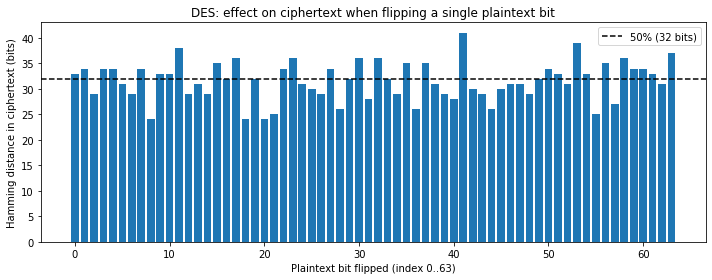

In [4]:
def des_encrypt_block(key8: bytes, block8: bytes) -> bytes:
    assert len(key8) == 8 and len(block8) == 8
    cipher = DES.new(key8, DES.MODE_ECB)
    return cipher.encrypt(block8)


# Avalanche test: flip one bit in plaintext

# %%
# Set a fixed key and plaintext for reproducibility
key = b"\x13\x34\x57\x79\x9b\xbc\xdf\xf1"  # classic DES test key
plain = b"\x01\x23\x45\x67\x89\xab\xcd\xef"  # classic test vector

ct0 = des_encrypt_block(key, plain)

# Try flipping each plaintext bit one by one and record hamming distances
n_bits = 64
plain_bit_changes = np.zeros(n_bits, dtype=np.int32)
for i in range(n_bits):
    p2 = flip_bit_in_bytes(plain, i)
    ct2 = des_encrypt_block(key, p2)
    plain_bit_changes[i] = hamming_distance(bytes_to_bits(ct0), bytes_to_bits(ct2))

print("DES real: flipping each plaintext bit (one at a time) -> ciphertext Hamming distances:")
print("mean: {:.2f}, min: {}, max: {}".format(plain_bit_changes.mean(), plain_bit_changes.min(), plain_bit_changes.max()))

# Plot histogram / bar chart
plt.figure(figsize=(10,4))
plt.bar(range(n_bits), plain_bit_changes)
plt.xlabel('Plaintext bit flipped (index 0..63)')
plt.ylabel('Hamming distance in ciphertext (bits)')
plt.title('DES: effect on ciphertext when flipping a single plaintext bit')
plt.axhline(32, color='k', linestyle='--', label='50% (32 bits)')
plt.legend()
plt.tight_layout()
plt.show()

So, bar at position 17 means:

“When plaintext bit #17 was flipped, 31 bits in the ciphertext changed.”

DES real: flipping each key bit (one at a time) -> ciphertext Hamming distances:
mean: 27.89, min: 0, max: 40


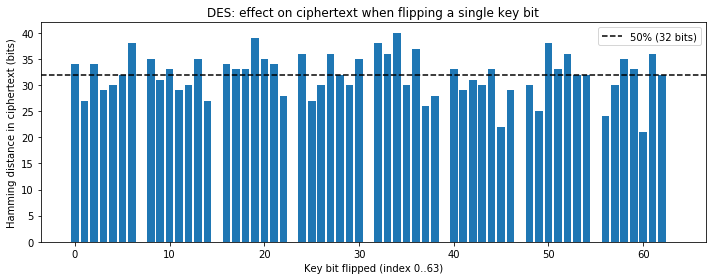

In [5]:
# %% [markdown]
# Avalanche test: flip one bit in the key (confusion)

# %%
key_bit_changes = np.zeros(n_bits, dtype=np.int32)
for i in range(n_bits):
    k2 = flip_bit_in_bytes(key, i)
    ct2 = des_encrypt_block(k2, plain)
    key_bit_changes[i] = hamming_distance(bytes_to_bits(ct0), bytes_to_bits(ct2))

print("DES real: flipping each key bit (one at a time) -> ciphertext Hamming distances:")
print("mean: {:.2f}, min: {}, max: {}".format(key_bit_changes.mean(), key_bit_changes.min(), key_bit_changes.max()))

plt.figure(figsize=(10,4))
plt.bar(range(n_bits), key_bit_changes)
plt.xlabel('Key bit flipped (index 0..63)')
plt.ylabel('Hamming distance in ciphertext (bits)')
plt.title('DES: effect on ciphertext when flipping a single key bit')
plt.axhline(32, color='k', linestyle='--', label='50% (32 bits)')
plt.legend()
plt.tight_layout()
plt.show()

# %% [markdown]
# Statistical experiment: random keys/plaintexts — show distribution of avalanche
# percentages when flipping one random plaintext bit (repeat many times)

This plot has a similar meaning: You see how many bits are modiffied when each single bit of the key is modified. 



## Bit-by-Bit Avalanche Plot (Single Plaintext Test)

In this experiment, we analyze **how each individual plaintext bit affects the ciphertext** when flipped. This directly tests **diffusion** in DES.

###  What the experiment does

1. Choose a **fixed plaintext** ( P ) and a **fixed key** ( K ).

2. Encrypt to get the original ciphertext:
   [
   C = DES(P, K)
   ]

3. For each bit position ( i = 0 \ldots 63 ):

   * Flip only bit ( i ) in the plaintext → ( P_i )
   * Encrypt again → ( C_i = DES(P_i, K) )
   * Compute the **Hamming distance** between ( C ) and ( C_i )
     (i.e., how many ciphertext bits changed)

4. Store all 64 distances.

5. Plot them as a **bar chart**, one bar per flipped plaintext bit.

---

###  What each bar means

Each bar answers:

> **“If I flip plaintext bit #i, how many ciphertext bits change?”**

* X-axis = plaintext bit index (0 to 63)
* Y-axis = number of ciphertext bits that changed (0 to 64)

We also draw a **horizontal dashed line at 32 bits**, which represents the **ideal avalanche effect** (50% of 64 bits).

---

###  What we expect from a secure cipher

In a cipher with strong **diffusion**:

* Most bars should be **close to 32** (around half the bits change)
* Few (or none) should be very low (e.g., < 15 bits changed)
* Few (or none) should be very high (e.g., > 50 bits changed)
* The pattern should look fairly **flat and consistent across all bits**

Why?
Because **every plaintext bit** should influence **many parts of the ciphertext**, not just a few specific bits.

---

###  What this plot tells us about DES

If DES is working correctly:

* Flipping any single plaintext bit results in **large, widespread changes** in the ciphertext.
* No plaintext bit has a “special” or “weak” position.
* The differences are roughly uniform across all 64 input bits.
* This shows **excellent diffusion** — a key design goal of DES.

---

###  Why this test is useful

This experiment reveals whether **each individual input bit** participates equally in the encryption process.

If some bits produced very low changes consistently, that would indicate:

* Poor mixing
* Potential for statistical patterns to leak
* A target for cryptanalysis

But DES avoids this ― the plot shows that **every bit is powerful**.

---

###  In one sentence:

**The bar chart shows how much the ciphertext changes when each individual plaintext bit is flipped; since nearly all bars are close to 32, DES demonstrates strong diffusion and the avalanche effect.**

---




Plaintext flips: mean percent changed = 49.80% (std 6.22)
Key flips: mean percent changed = 44.53% (std 17.24)


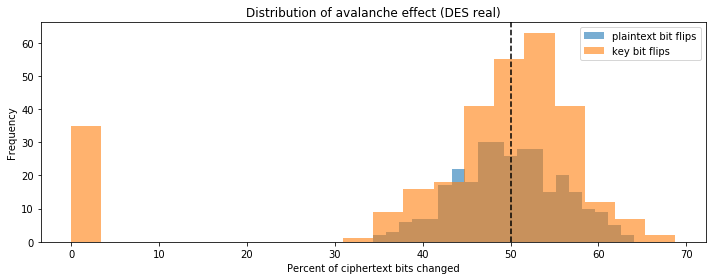

In [6]:
import random

def avalanche_experiment_real(num_trials=200, flip_key=False):
    distances = []
    for _ in range(num_trials):
        key_r = get_random_bytes(8)
        plain_r = get_random_bytes(8)
        ct = des_encrypt_block(key_r, plain_r)
        # flip a random plaintext bit or key bit
        if not flip_key:
            i = random.randrange(64)
            plain_r2 = flip_bit_in_bytes(plain_r, i)
            ct2 = des_encrypt_block(key_r, plain_r2)
        else:
            i = random.randrange(64)
            key_r2 = flip_bit_in_bytes(key_r, i)
            ct2 = des_encrypt_block(key_r2, plain_r)
        distances.append(percent_changed(bytes_to_bits(ct), bytes_to_bits(ct2)))
    return np.array(distances)

# Run experiments
plain_flip_stats = avalanche_experiment_real(300, flip_key=False)
key_flip_stats = avalanche_experiment_real(300, flip_key=True)

print("Plaintext flips: mean percent changed = {:.2f}% (std {:.2f})".format(plain_flip_stats.mean(), plain_flip_stats.std()))
print("Key flips: mean percent changed = {:.2f}% (std {:.2f})".format(key_flip_stats.mean(), key_flip_stats.std()))

plt.figure(figsize=(10,4))
plt.hist(plain_flip_stats, bins=20, alpha=0.6, label='plaintext bit flips')
plt.hist(key_flip_stats, bins=20, alpha=0.6, label='key bit flips')
plt.axvline(50, color='k', linestyle='--')
plt.xlabel('Percent of ciphertext bits changed')
plt.ylabel('Frequency')
plt.title('Distribution of avalanche effect (DES real)')
plt.legend()
plt.tight_layout()
plt.show()



---

## Understanding the Manual DES Plots (Per-Round Diffusion & S-box Micro-Examples)

This part of the notebook uses a **manual, didactic DES implementation** to illustrate how **confusion and diffusion** arise inside the cipher. Unlike the black-box `pycryptodome` implementation, the manual version allows us to **inspect internal states** at every round.

---

### Per-Round Diffusion Plot

* **Plot:** Hamming distance of `(L||R)` states per round when flipping **one plaintext bit**.
* **X-axis:** Round number (1 to 16)
* **Y-axis:** Hamming distance between baseline and modified internal state (0 to 64 bits)

**Interpretation:**

* In early rounds, only a few bits differ.
* As rounds progress, differences propagate across the block → avalanche effect grows.
* By round 16, a single-bit change typically affects **almost all 64 bits**.
* This demonstrates **diffusion**: a small input change spreads throughout the ciphertext over successive rounds.

---

### Round-1 Internals (Confusion vs Diffusion)

* **Shown values:**

  * `E(R)` → expanded 32-bit half-block
  * XOR with subkey → input to S-boxes
  * S-box output → 32-bit non-linear substitution
  * P-permutation → final round output

**Interpretation:**

* The S-boxes introduce **non-linearity** → a tiny input change drastically alters output bits → **confusion**
* The P-permutation and expansion mix bits across the block → contributes to **diffusion**
* Observing Hamming distance in `f(R,K)` between baseline and flipped input illustrates **how a 1-bit change rapidly multiplies** inside a single round.

---

### S-box Micro-Example

* **Purpose:** Show how flipping **1 bit in the 6-bit S-box input** can change **multiple output bits**.
* **Observation:** Even the smallest input difference (1 bit) can produce 1–4 output bits flipped.
* This highlights **non-linear confusion**, making it difficult to relate ciphertext to plaintext or key.

---

### Heatmap of Ciphertext Differences

* **Plot:** 8×8 grid representing each plaintext bit (bit 0 → row 0, col 0; …; bit 63 → row 7, col 7)
* **Color:** Hamming distance of ciphertext bits when that plaintext bit is flipped
* **Interpretation:**

  * Visualizes **diffusion across the block**: all plaintext bits influence ciphertext uniformly
  * Confirms that no bit has a privileged position → strong avalanche effect
  * Easy to see the statistical **stability of the avalanche effect**

---

### Final comments

* **Manual inspection** helps distinguish the roles of:

  * **Confusion:** S-boxes make the mapping from input/key to output highly non-linear
  * **Diffusion:** P-permutation and expansion spread changes throughout the block
* By stepping through rounds, students can **observe how single-bit changes propagate** and understand why DES achieves strong avalanche behavior
* Can extend experiments:

  * Flip key bits and track per-round propagation
  * Compare different keys and plaintexts
  * Explore reduced-round DES to see weaker diffusion

---

### Summary

These plots and tables collectively demonstrate Shannon’s principles:

1. **Diffusion:** a single bit change in plaintext spreads across many ciphertext bits over rounds.
2. **Confusion:** non-linear S-boxes make ciphertext highly sensitive to both plaintext and key bits.
3. **Avalanche Effect:** after 16 rounds, a single-bit change typically flips roughly half of the ciphertext bits, providing cryptographic strength.

---

This Markdown clearly explains all the visualizations from the manual DES section and ties them to the concepts of **confusion, diffusion, and avalanche effect**.



## Manual (didactic) DES implementation (compact)

The purpose of the manual implementation is *not* performance but visibility: we'll implement the important parts: IP, expansion E, S-boxes, P-permutation, key schedule (PC-1 / shifts / PC-2), and the Feistel rounds. This lets us print intermediate values inside the round function to illustrate confusion/diffusion.

In [7]:

# Standard DES tables (IP, FP, E, S-boxes, P, PC-1, PC-2, shifts)
IP = [58, 50, 42, 34, 26, 18, 10, 2,
      60, 52, 44, 36, 28, 20, 12, 4,
      62, 54, 46, 38, 30, 22, 14, 6,
      64, 56, 48, 40, 32, 24, 16, 8,
      57, 49, 41, 33, 25, 17, 9, 1,
      59, 51, 43, 35, 27, 19, 11, 3,
      61, 53, 45, 37, 29, 21, 13, 5,
      63, 55, 47, 39, 31, 23, 15, 7]
FP = [40, 8, 48, 16, 56, 24, 64, 32,
      39, 7, 47, 15, 55, 23, 63, 31,
      38, 6, 46, 14, 54, 22, 62, 30,
      37, 5, 45, 13, 53, 21, 61, 29,
      36, 4, 44, 12, 52, 20, 60, 28,
      35, 3, 43, 11, 51, 19, 59, 27,
      34, 2, 42, 10, 50, 18, 58, 26,
      33, 1, 41, 9, 49, 17, 57, 25]
E = [32, 1, 2, 3, 4, 5,
     4, 5, 6, 7, 8, 9,
     8, 9, 10, 11, 12, 13,
     12, 13, 14, 15, 16, 17,
     16, 17, 18, 19, 20, 21,
     20, 21, 22, 23, 24, 25,
     24, 25, 26, 27, 28, 29,
     28, 29, 30, 31, 32, 1]

S_boxes = [
    # S1
    [
        [14,4,13,1,2,15,11,8,3,10,6,12,5,9,0,7],
        [0,15,7,4,14,2,13,1,10,6,12,11,9,5,3,8],
        [4,1,14,8,13,6,2,11,15,12,9,7,3,10,5,0],
        [15,12,8,2,4,9,1,7,5,11,3,14,10,0,6,13]
    ],
    # S2
    [
        [15,1,8,14,6,11,3,4,9,7,2,13,12,0,5,10],
        [3,13,4,7,15,2,8,14,12,0,1,10,6,9,11,5],
        [0,14,7,11,10,4,13,1,5,8,12,6,9,3,2,15],
        [13,8,10,1,3,15,4,2,11,6,7,12,0,5,14,9]
    ],
    # S3
    [
        [10,0,9,14,6,3,15,5,1,13,12,7,11,4,2,8],
        [13,7,0,9,3,4,6,10,2,8,5,14,12,11,15,1],
        [13,6,4,9,8,15,3,0,11,1,2,12,5,10,14,7],
        [1,10,13,0,6,9,8,7,4,15,14,3,11,5,2,12]
    ],
    # S4
    [
        [7,13,14,3,0,6,9,10,1,2,8,5,11,12,4,15],
        [13,8,11,5,6,15,0,3,4,7,2,12,1,10,14,9],
        [10,6,9,0,12,11,7,13,15,1,3,14,5,2,8,4],
        [3,15,0,6,10,1,13,8,9,4,5,11,12,7,2,14]
    ],
    # S5
    [
        [2,12,4,1,7,10,11,6,8,5,3,15,13,0,14,9],
        [14,11,2,12,4,7,13,1,5,0,15,10,3,9,8,6],
        [4,2,1,11,10,13,7,8,15,9,12,5,6,3,0,14],
        [11,8,12,7,1,14,2,13,6,15,0,9,10,4,5,3]
    ],
    # S6
    [
        [12,1,10,15,9,2,6,8,0,13,3,4,14,7,5,11],
        [10,15,4,2,7,12,9,5,6,1,13,14,0,11,3,8],
        [9,14,15,5,2,8,12,3,7,0,4,10,1,13,11,6],
        [4,3,2,12,9,5,15,10,11,14,1,7,6,0,8,13]
    ],
    # S7
    [
        [4,11,2,14,15,0,8,13,3,12,9,7,5,10,6,1],
        [13,0,11,7,4,9,1,10,14,3,5,12,2,15,8,6],
        [1,4,11,13,12,3,7,14,10,15,6,8,0,5,9,2],
        [6,11,13,8,1,4,10,7,9,5,0,15,14,2,3,12]
    ],
    # S8
    [
        [13,2,8,4,6,15,11,1,10,9,3,14,5,0,12,7],
        [1,15,13,8,10,3,7,4,12,5,6,11,0,14,9,2],
        [7,11,4,1,9,12,14,2,0,6,10,13,15,3,5,8],
        [2,1,14,7,4,10,8,13,15,12,9,0,3,5,6,11]
    ]
]

P = [16,7,20,21,29,12,28,17,
     1,15,23,26,5,18,31,10,
     2,8,24,14,32,27,3,9,
     19,13,30,6,22,11,4,25]

PC1 = [57,49,41,33,25,17,9,
       1,58,50,42,34,26,18,
       10,2,59,51,43,35,27,
       19,11,3,60,52,44,36,
       63,55,47,39,31,23,15,
       7,62,54,46,38,30,22,
       14,6,61,53,45,37,29,
       21,13,5,28,20,12,4]

PC2 = [14,17,11,24,1,5,
       3,28,15,6,21,10,
       23,19,12,4,26,8,
       16,7,27,20,13,2,
       41,52,31,37,47,55,
       30,40,51,45,33,48,
       44,49,39,56,34,53,
       46,42,50,36,29,32]

# number of left shifts per round
SHIFTS = [1, 1, 2, 2, 2, 2, 2, 2,
          1, 2, 2, 2, 2, 2, 2, 1]

# Auxiliar permutation function (1-indexed table)
def permute(bits: np.ndarray, table: list) -> np.ndarray:
    # bits is numpy array of 0/1, 1-indexed positions in table
    out = np.zeros(len(table), dtype=np.uint8)
    for i, pos in enumerate(table):
        out[i] = bits[pos-1]
    return out

# left rotate for key halves

def left_rotate(bits: np.ndarray, n: int) -> np.ndarray:
    return np.concatenate([bits[n:], bits[:n]])



### Build the DES key schedule (16 subkeys of 48 bits):


In [8]:
def key_schedule_48(key8: bytes) -> list:
    bits = bytes_to_bits(key8)
    # apply PC-1
    perm = permute(bits, PC1)
    C = perm[:28].copy()
    D = perm[28:].copy()
    subkeys = []
    for shift in SHIFTS:
        C = left_rotate(C, shift)
        D = left_rotate(D, shift)
        CD = np.concatenate([C, D])
        subk = permute(CD, PC2)
        subkeys.append(subk)
    return subkeys


### The Feistel round function f(R, K): Expand, XOR, S-boxes, P-permute


In [9]:
def sbox_substitution(bits48: np.ndarray) -> np.ndarray:
    out = np.zeros(32, dtype=np.uint8)
    for i in range(8):
        block6 = bits48[i*6:(i+1)*6]
        row = (block6[0] << 1) | block6[5]
        col = (block6[1] << 3) | (block6[2] << 2) | (block6[3] << 1) | block6[4]
        val = S_boxes[i][row][col]
        for j in range(4):
            out[i*4 + (3-j)] = (val >> j) & 1
    return out


def feistel_f(R32: np.ndarray, K48: np.ndarray, debug=False):
    # Expand
    E_R = permute(R32, E)
    if debug:
        print('E(R):', bits_str(E_R))
    # XOR with subkey
    x = np.bitwise_xor(E_R, K48)
    if debug:
        print('E(R) XOR K:', bits_str(x))
    # S-box substitution
    s_out = sbox_substitution(x)
    if debug:
        print('S-box output (32 bits):', bits_str(s_out))
    # P-permutation
    p_out = permute(s_out, P)
    if debug:
        print('P-permutation:', bits_str(p_out))
    return p_out


### Full DES encrypt (manual) for one 64-bit block



In [10]:
def des_encrypt_manual(key8: bytes, block8: bytes, debug_round=None):
    # returns ciphertext bytes and, optionally, per-round trace if debug_round is not None
    bits = bytes_to_bits(block8)
    ip = permute(bits, IP)
    L = ip[:32].copy()
    R = ip[32:].copy()
    subkeys = key_schedule_48(key8)
    traces = []
    for r in range(16):
        K = subkeys[r]
        f_out = feistel_f(R, K, debug=(debug_round==r+1))
        newL = R.copy()
        newR = np.bitwise_xor(L, f_out)
        L, R = newL, newR
        traces.append({'round': r+1, 'L': L.copy(), 'R': R.copy(), 'f': f_out.copy(), 'K': K.copy()})
    preout = np.concatenate([R, L])
    cipher_bits = permute(preout, FP)
    return bits_to_bytes(cipher_bits), traces

# Quick check: encryption should match pycryptodome for the test vector
manual_ct, _ = des_encrypt_manual(key, plain)
ct_ref = des_encrypt_block(key, plain)
print('Manual DES matches pycryptodome reference?', manual_ct == ct_ref)

Manual DES matches pycryptodome reference? True



### Use the manual implementation to inspect how single-bit changes propagate across rounds



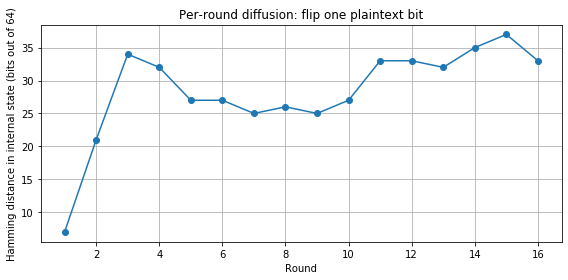

In [11]:
# %%
# Pick a key and plaintext and show per-round Hamming distances when flipping one plaintext bit
key_demo = key
plain_demo = plain

# baseline per-round results
_, traces_base = des_encrypt_manual(key_demo, plain_demo)

# flip a single plaintext bit (choose bit index 0 for demonstration)
plain_flip = flip_bit_in_bytes(plain_demo, 0)
_, traces_flip = des_encrypt_manual(key_demo, plain_flip)

# compute per-round Hamming distances between (L||R) states
per_round_hd = []
for r in range(16):
    bits_base = np.concatenate([traces_base[r]['L'], traces_base[r]['R']])
    bits_flip = np.concatenate([traces_flip[r]['L'], traces_flip[r]['R']])
    per_round_hd.append(hamming_distance(bits_base, bits_flip))

plt.figure(figsize=(8,4))
plt.plot(range(1,17), per_round_hd, marker='o')
plt.xlabel('Round')
plt.ylabel('Hamming distance in internal state (bits out of 64)')
plt.title('Per-round diffusion: flip one plaintext bit')
plt.grid(True)
plt.tight_layout()
plt.show()

In [15]:

# Inspect round 1 internals to highlight *confusion* vs *diffusion*:
# - show expansion E(R), XOR with subkey, S-box outputs, P permutation, and resulting new R

# %%
round_to_inspect = 1
print('=== Round', round_to_inspect, 'baseline ===')
print('L (before):', bits_str(traces_base[0]['L']))
print('R (before):', bits_str(traces_base[0]['R']))
print('Subkey K:', bits_str(traces_base[0]['K']))
print('f(R,K):', bits_str(traces_base[0]['f']))
print('\n=== Round', round_to_inspect, 'with plaintext bit flipped ===')
print('L (before):', bits_str(traces_flip[0]['L']))
print('R (before):', bits_str(traces_flip[0]['R']))
print('Subkey K (same):', bits_str(traces_flip[0]['K']))
print('f(R,K):', bits_str(traces_flip[0]['f']))

print('\nHamming distance in f(R,K) between baseline and flipped input:', hamming_distance(traces_base[0]['f'], traces_flip[0]['f']))



=== Round 1 baseline ===
L (before): 11110000101010101111000010101010
R (before): 11101111010010100110010101000100
Subkey K: 000110110000001011101111111111000111000001110010
f(R,K): 00100011010010101010100110111011

=== Round 1 with plaintext bit flipped ===
L (before): 11110001101010101111000010101010
R (before): 11101011010000110110010001010000
Subkey K (same): 000110110000001011101111111111000111000001110010
f(R,K): 00100111010000111010100010101111

Hamming distance in f(R,K) between baseline and flipped input: 6


In [16]:
# %% [markdown]
# S-box micro-example: show how a 1-bit change to a 6-bit input of an S-box can change the 4-bit output

# %%
# pick S-box 1, input 6-bit patterns that differ by 1 bit
sbox_idx = 0
input_a = np.array([0,0,0,0,0,0], dtype=np.uint8)
# flip bit 2 (indexing 0..5)
input_b = input_a.copy(); input_b[2] = 1

row_a = (input_a[0] << 1) | input_a[5]
col_a = (input_a[1] << 3) | (input_a[2] << 2) | (input_a[3] << 1) | input_a[4]
val_a = S_boxes[sbox_idx][row_a][col_a]
row_b = (input_b[0] << 1) | input_b[5]
col_b = (input_b[1] << 3) | (input_b[2] << 2) | (input_b[3] << 1) | input_b[4]
val_b = S_boxes[sbox_idx][row_b][col_b]

print('S-box #1 input A:', bits_str(input_a), '->', format(val_a, '04b'))
print('S-box #1 input B:', bits_str(input_b), '->', format(val_b, '04b'))
print('Hamming distance between outputs:', bin(val_a ^ val_b).count('1'))

S-box #1 input A: 000000 -> 1110
S-box #1 input B: 001000 -> 0010
Hamming distance between outputs: 2


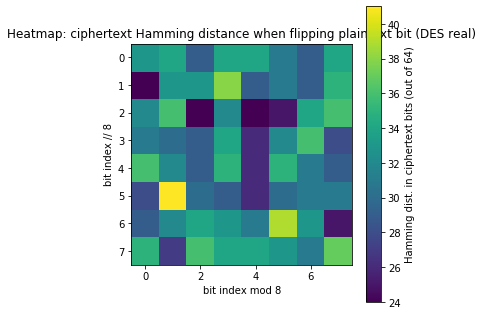

In [17]:




# %% [markdown]
# Visual summary: heatmap of ciphertext differences when flipping each plaintext bit

# %%
# Build a 8x8 heatmap matrix where row*8+col is plaintext bit flipped index
ct_bits_baseline = bytes_to_bits(des_encrypt_block(key, plain))
heat = np.zeros((8,8), dtype=np.uint8)
for i in range(64):
    p2 = flip_bit_in_bytes(plain, i)
    ct2 = des_encrypt_block(key, p2)
    hd = hamming_distance(ct_bits_baseline, bytes_to_bits(ct2))
    heat[i//8, i%8] = hd

plt.figure(figsize=(6,5))
plt.imshow(heat, interpolation='nearest')
plt.colorbar(label='Hamming dist. in ciphertext bits (out of 64)')
plt.title('Heatmap: ciphertext Hamming distance when flipping plaintext bit (DES real)')
plt.xlabel('bit index mod 8')
plt.ylabel('bit index // 8')
plt.tight_layout()
plt.show()
